In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    transcriptor, rev_comp, lbl2lbl_id, lbl_id2lbl, collapse_mutspec
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, _prepare_nice_labels, plot_mutspec96
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

from utils import calc_mutspec_class, sbs2effect, effect2sbs, collapse_sbs192, complete_sbs_columns

sns.set_style()

In [2]:
possible_sbs6 = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
possible_sbs96 = [x for x in possible_sbs192 if x[2:5] in possible_sbs6]
print(possible_sbs96)

['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 'G[T>G]A', 'G[T>G]C', 'G[T>G]G'

## Load and prepare data

In [3]:
species_spectra = pd.read_csv('../data/MutSpecVertebratescytb.csv')
cosmic = pd.read_table('../data/external/COSMIC_v3.3.1_SBS_GRCh37.txt', index_col=0)

In [4]:
species_spectra.head(2)

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii


Drop SBS without transitions

In [5]:
transitions_sbs = ['C>T', 'A>G', 'G>A', 'T>C'] 
transversions_sbs = [x for x in possible_sbs12 if x not in transitions_sbs]

cutoff_ts_share = 0.25
x = cosmic.loc[cosmic.index.str.slice(2,5).isin(transitions_sbs)].sum() 
used_sbs =  x[x > cutoff_ts_share].index.values
cosmic_filtered = cosmic[used_sbs]

#Reformat cosmic table
cosmic_filtered = cosmic_filtered.T[possible_sbs96]

cosmic_filtered.head().round(4)

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
SBS1,0.0009,0.0023,0.0002,0.0013,0.0003,0.0018,0.0001,0.0000,0.0016,0.0003,...,0.0001,0.0002,0.0000,0.0000,0.0003,0.0000,0.0000,0.0001,0.0006,0.0000
SBS2,0.0000,0.0001,0.0001,0.0001,0.0002,0.0001,0.0000,0.0004,0.0001,0.0000,...,0.0001,0.0002,0.0002,0.0001,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000
SBS3,0.0208,0.0165,0.0018,0.0122,0.0225,0.0253,0.0025,0.0154,0.0071,0.0109,...,0.0107,0.0070,0.0044,0.0023,0.0109,0.0058,0.0073,0.0063,0.0081,0.0105
SBS5,0.0120,0.0094,0.0018,0.0066,0.0074,0.0061,0.0035,0.0065,0.0102,0.0076,...,0.0061,0.0073,0.0025,0.0017,0.0053,0.0023,0.0052,0.0066,0.0069,0.0135
SBS6,0.0004,0.0005,0.0001,0.0002,0.0018,0.0041,0.0017,0.0096,0.0004,0.0009,...,0.0009,0.0013,0.0000,0.0002,0.0003,0.0008,0.0001,0.0003,0.0003,0.0010


Filter out species without nice spectrum:
at least 16 mtypes and 40 observed mutations

In [6]:
gr1 = species_spectra[~(species_spectra.MutSpec <= 0)].groupby("Species").Mut.count()
gr2 = species_spectra.groupby("Species").Observed.sum()
assert (gr1.index == gr2.index).all()
used_species = gr1[(gr1 > 16) & (gr2 > 40)].index.values
print(len(used_species))

species_spectra = species_spectra[species_spectra.Species.isin(used_species)]

643


In [7]:
cls_spectra = calc_mutspec_class(species_spectra)
for d in [cls_spectra, species_spectra]:
    d["sbs192h"] = d.Mut
    d["sbs12h"]  = d["sbs192h"].str.slice(2, 5)
    # d["sbs192l"] = d["sbs192h"].apply(rev_comp)
    # d["sbs12l"]  = d["sbs12h"].str.translate(transcriptor)
cls_spectra

,Class,Mut,MutSpec,sbs192h,sbs12h
0,Actinopterygii,A[A>C]A,0.000914,A[A>C]A,A>C
1,Actinopterygii,A[A>C]C,0.001387,A[A>C]C,A>C
2,Actinopterygii,A[A>C]G,0.000192,A[A>C]G,A>C
3,Actinopterygii,A[A>C]T,0.000000,A[A>C]T,A>C
4,Actinopterygii,A[A>G]A,0.010816,A[A>G]A,A>G
...,...,...,...,...,...
955,Mammalia,T[T>C]T,0.001801,T[T>C]T,T>C
956,Mammalia,T[T>G]A,0.000316,T[T>G]A,T>G
957,Mammalia,T[T>G]C,0.000406,T[T>G]C,T>G
958,Mammalia,T[T>G]G,0.000590,T[T>G]G,T>G


In [8]:
# mean num of mutations in single species from each class
species_spectra.groupby(["Class", "Species"]).Observed.sum().mean(level=0)

Class
Actinopterygii    184.824818
Amphibia          172.954545
Aves              111.411765
Lepidosauria      207.645161
Mammalia          181.570922
Name: Observed, dtype: float64

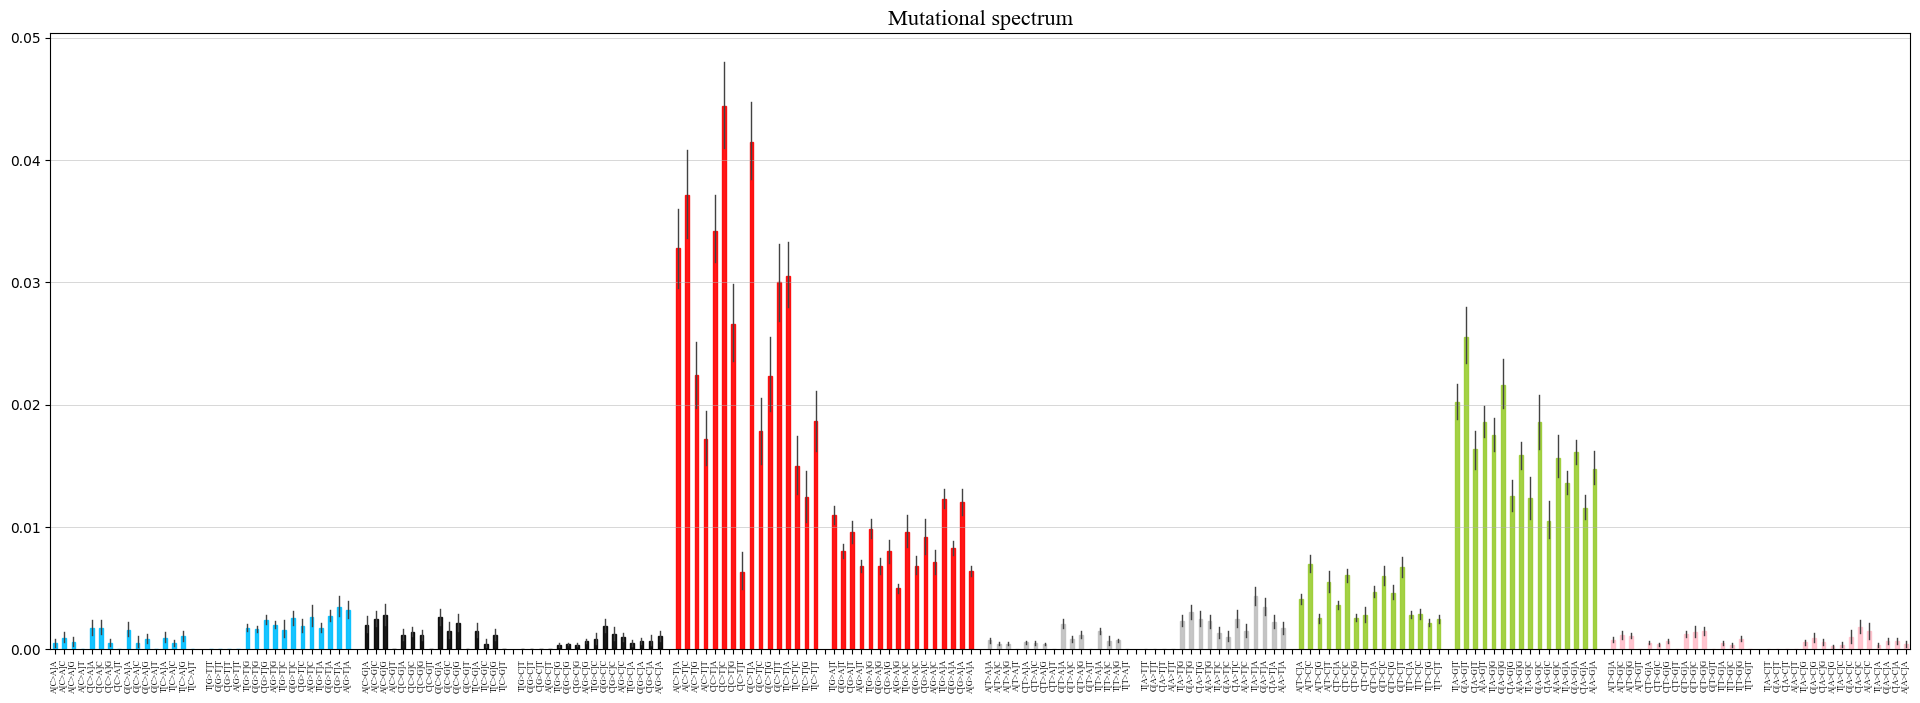

In [9]:
plot_mutspec192(species_spectra)

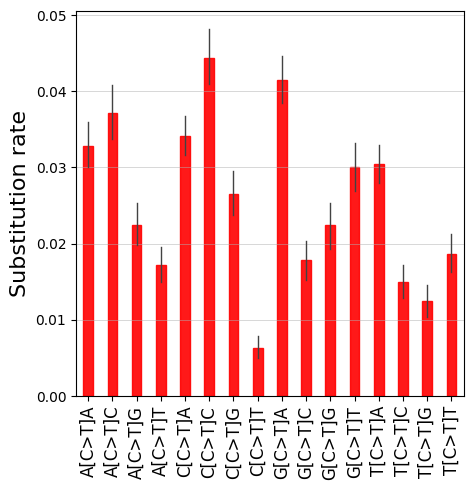

In [12]:
plot_mutspec192(species_spectra, title="", ylabel="Substitution rate",  fontname="Courier", 
                ticksize=12, sbs_order=ordered_sbs192_kp[64:64+16], figsize=(5, 5), savepath="../pictures/fig5a.pdf")

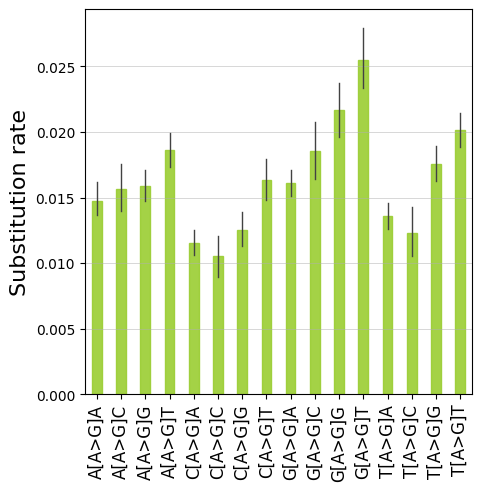

In [13]:
plot_mutspec192(species_spectra, title="", ylabel="Substitution rate", fontname="Courier", 
                ticksize=12, sbs_order=sorted(ordered_sbs192_kp[16*9:16*9+16]), figsize=(5, 5), savepath="../pictures/fig5b.pdf")

In [30]:
matplotlib.font_manager.findfont("Courier")

'/home/kpotoh/mtdna-192component-mutspec-chordata/env_192/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [28]:
[x for x in matplotlib.font_manager.findSystemFonts() if "Cou" in x]

['/usr/share/fonts/truetype/croscore/Cousine-Regular.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Courier_New_Bold.ttf',
 '/usr/share/fonts/truetype/croscore/Cousine-Italic.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Courier_New_Bold_Italic.ttf',
 '/usr/share/fonts/truetype/croscore/Cousine-BoldItalic.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Courier-New.ttf',
 '/usr/share/fonts/truetype/croscore/Cousine-Bold.ttf',
 '/usr/share/fonts/truetype/msttcorefonts/Courier_New_Italic.ttf']

## Direct compare with signatures by CosSim
species-wise & cls-wise

transversions are NA

### Prepare species dataset

1. only transitions on light 
2. only C>T (light)
3. only A>G (light)

In [9]:
species_ct_raw = species_spectra[species_spectra.sbs12h == "G>A"]
species_ct_raw['sbs96'] = species_ct_raw.sbs192h.apply(rev_comp)

species_ag_raw = species_spectra[species_spectra.sbs12h == "T>C"]
species_ag_raw['sbs96'] = species_ag_raw.sbs192h

species_transitions_raw = pd.concat([species_ct_raw, species_ag_raw], ignore_index=True)

species_ct = complete_sbs_columns(species_ct_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack())
species_ag = complete_sbs_columns(species_ag_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack())
species_transitions = complete_sbs_columns(species_transitions_raw\
        .groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack())

assert (species_transitions.columns.values == cosmic_filtered.columns.values).all()
assert (species_ct.columns.values == cosmic_filtered.columns.values).all()
assert (species_ag.columns.values == cosmic_filtered.columns.values).all()

species_transitions.head(5).round(4)

sbs96                                      A[C>A]A  A[C>A]C  A[C>A]G  A[C>A]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0      0.0      0.0   
               Acanthopagrus_schlegelii        0.0      0.0      0.0      0.0   
               Acheilognathus_macropterus      0.0      0.0      0.0      0.0   
               Acheilognathus_rhombeus         0.0      0.0      0.0      0.0   
               Acheilognathus_signifer         0.0      0.0      0.0      0.0   

sbs96                                      C[C>A]A  C[C>A]C  C[C>A]G  C[C>A]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0      0.0      0.0   
               Acanthopagrus_schlegelii        0.0      0.0      0.0      0.0   
               Acheilognathus_macropterus      0.0      0.0      0.0      0.0   
               Acheilognathus_rhombeus         0.0      0.0      0.0      0.0   
               Acheilognathus_signifer         0.0      0.0      0.0      0.0   

sbs96                                      G[C>A]A  G[C>A]C  ...  C[T>G]G  \
Class          Species                                       ...            
Actinopterygii Abbottina_rivularis             0.0      0.0  ...      0.0   
               Acanthopagrus_schlegelii        0.0      0.0  ...      0.0   
               Acheilognathus_macropterus      0.0      0.0  ...      0.0   
               Acheilognathus_rhombeus         0.0      0.0  ...      0.0   
               Acheilognathus_signifer         0.0      0.0  ...      0.0   

sbs96                                      C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0      0.0      0.0   
               Acanthopagrus_schlegelii        0.0      0.0      0.0      0.0   
               Acheilognathus_macropterus      0.0      0.0      0.0      0.0   
               Acheilognathus_rhombeus         0.0      0.0      0.0      0.0   
               Acheilognathus_signifer         0.0      0.0      0.0      0.0   

sbs96                                      G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0      0.0      0.0   
               Acanthopagrus_schlegelii        0.0      0.0      0.0      0.0   
               Acheilognathus_macropterus      0.0      0.0      0.0      0.0   
               Acheilognathus_rhombeus         0.0      0.0      0.0      0.0   
               Acheilognathus_signifer         0.0      0.0      0.0      0.0   

sbs96                                      T[T>G]T  
Class          Species                              
Actinopterygii Abbottina_rivularis             0.0  
               Acanthopagrus_schlegelii        0.0  
               Acheilognathus_macropterus      0.0  
               Acheilognathus_rhombeus         0.0  
               Acheilognathus_signifer         0.0  

[5 rows x 96 columns]

### Compare transitions<sub>L</sub> with COSMIC

In [16]:
# the table contain similarity of secies (index) versus signature (column)
sim = pd.DataFrame(1 - cdist(species_transitions, cosmic_filtered, "cosine"), index=species_transitions.index, columns=cosmic_filtered.index)
sim

SBS1      SBS2      SBS3  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.237850  0.406132  0.449754   
               Acanthopagrus_schlegelii    0.348301  0.657317  0.263709   
               Acheilognathus_macropterus  0.332409  0.456732  0.361321   
               Acheilognathus_rhombeus     0.020561  0.379603  0.412598   
               Acheilognathus_signifer     0.459279  0.624128  0.308982   
...                                             ...       ...       ...   
Mammalia       Varecia_variegata           0.046736  0.163261  0.328896   
               Vicugna_vicugna             0.014670  0.000278  0.282282   
               Viverricula_indica          0.420203  0.373973  0.213122   
               Vulpes_lagopus              0.034121  0.090018  0.282773   
               Vulpes_vulpes               0.250683  0.320321  0.399643   

                                               SBS5      SBS6     SBS7a  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.656387  0.426834  0.585976   
               Acanthopagrus_schlegelii    0.460153  0.454916  0.541655   
               Acheilognathus_macropterus  0.612090  0.454359  0.504816   
               Acheilognathus_rhombeus     0.603016  0.275148  0.491897   
               Acheilognathus_signifer     0.535895  0.535078  0.681476   
...                                             ...       ...       ...   
Mammalia       Varecia_variegata           0.464827  0.104148  0.477460   
               Vicugna_vicugna             0.426147  0.125491  0.048115   
               Viverricula_indica          0.413331  0.699754  0.377983   
               Vulpes_lagopus              0.325608  0.060675  0.147686   
               Vulpes_vulpes               0.633520  0.404880  0.555004   

                                              SBS7b     SBS7c     SBS7d  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.676350  0.134878  0.383944   
               Acanthopagrus_schlegelii    0.308508  0.072114  0.047823   
               Acheilognathus_macropterus  0.411374  0.106969  0.193541   
               Acheilognathus_rhombeus     0.405903  0.106075  0.421520   
               Acheilognathus_signifer     0.568239  0.146869  0.285014   
...                                             ...       ...       ...   
Mammalia       Varecia_variegata           0.578804  0.072561  0.664579   
               Vicugna_vicugna             0.169932  0.034182  0.627053   
               Viverricula_indica          0.302256  0.050297  0.057945   
               Vulpes_lagopus              0.224660  0.071608  0.061958   
               Vulpes_vulpes               0.666811  0.076069  0.264424   

                                               SBS9  ...     SBS58     SBS84  \
Class          Species                               ...                       
Actinopterygii Abbottina_rivularis         0.271118  ...  0.482127  0.496275   
               Acanthopagrus_schlegelii    0.140574  ...  0.226336  0.361474   
               Acheilognathus_macropterus  0.257857  ...  0.408311  0.526007   
               Acheilognathus_rhombeus     0.293447  ...  0.329746  0.500128   
               Acheilognathus_signifer     0.221184  ...  0.355129  0.279599   
...                                             ...  ...       ...       ...   
Mammalia       Varecia_variegata           0.184410  ...  0.309766  0.160957   
               Vicugna_vicugna             0.226661  ...  0.102748  0.288943   
               Viverricula_indica          0.126510  ...  0.158102  0.313296   
               Vulpes_lagopus              0.197884  ...  0.114484  0.088152   
               Vulpes_vulpes               0.239639  ...  0.266877  0.479844   

                                              SBS85     SBS87     SBS88  \
Cla

In [34]:
# mean similarity of species from entire class VERSUS COSMIC signatures
a = sim.mean(axis=0, level=0).T.sort_values("Aves", ascending=False)
a["Effect"] = a.index.map(sbs2effect)
a.head(10)

Class,Actinopterygii,Amphibia,Aves,Lepidosauria,Mammalia,Effect
SBS6,0.390310,0.494672,0.464409,0.471069,0.478731,MMR_deficiency
SBS5,0.507815,0.541234,0.455450,0.501636,0.524530,UNK_clock_like
SBS30,0.439871,0.540439,0.406125,0.509520,0.556436,BER_deficiency
SBS1,0.261665,0.339856,0.384412,0.286635,0.330603,C_deamination
SBS92,0.414083,0.435397,0.378511,0.385394,0.417338,Tobacco
SBS32,0.384201,0.457809,0.362335,0.437039,0.484830,Treatment
SBS87,0.245577,0.311589,0.359529,0.241583,0.321511,Treatment
SBS15,0.305341,0.373208,0.343538,0.388443,0.344314,MMR_deficiency
SBS44,0.368960,0.417338,0.336936,0.418132,0.399452,MMR_deficiency
SBS23,0.302501,0.382829,0.332877,0.410273,0.428468,NaN


Bad similarity. Need to split transitions to CT and AG

### C<sub>L</sub>>T<sub>L</sub> vs COSMIC

In [35]:
sim_ct = pd.DataFrame(1 - cdist(species_ct, cosmic_filtered, "cosine"), index=species_ct.index, columns=cosmic_filtered.index)
a = sim_ct.mean(axis=0, level=0).T.sort_values("Aves", ascending=False)
a["Effect"] = a.index.map(sbs2effect)
a.head(10)

Class,Actinopterygii,Amphibia,Aves,Lepidosauria,Mammalia,Effect
SBS6,0.490257,0.567847,0.543535,0.560029,0.540977,MMR_deficiency
SBS30,0.576290,0.623701,0.508271,0.619002,0.642927,BER_deficiency
SBS1,0.330127,0.386064,0.448145,0.340577,0.368709,C_deamination
SBS32,0.480144,0.514412,0.432554,0.511162,0.543386,Treatment
SBS23,0.396059,0.438670,0.412781,0.504128,0.497941,NaN
SBS87,0.285728,0.329948,0.403237,0.268522,0.342706,Treatment
SBS11,0.418581,0.443532,0.394828,0.486949,0.503773,Treatment
SBS7b,0.389846,0.418778,0.394421,0.421035,0.460131,UV
SBS15,0.364183,0.422193,0.382739,0.447909,0.377492,MMR_deficiency
SBS19,0.396134,0.427387,0.380577,0.441678,0.441647,NaN


Better similarity, but same still bad

### A<sub>L</sub>>G<sub>L</sub> vs COSMIC

In [39]:
sim_ag = pd.DataFrame(1 - cdist(species_ag, cosmic_filtered, "cosine"), index=species_ag.index, columns=cosmic_filtered.index)
a = sim_ag.mean(axis=0, level=0).T.sort_values("Aves", ascending=False)
a["Effect"] = a.index.map(sbs2effect)
a.head(10)

Class,Actinopterygii,Amphibia,Aves,Lepidosauria,Mammalia,Effect
SBS12,0.588003,0.568647,0.500184,0.518796,0.551223,NaN
SBS26,0.558652,0.545672,0.477805,0.491049,0.523494,MMR_deficiency
SBS21,0.445286,0.402295,0.438726,0.430666,0.447860,MMR_deficiency
SBS46,0.536072,0.545782,0.425086,0.557130,0.522717,Artifact
SBS37,0.486886,0.470639,0.400415,0.432219,0.465840,NaN
SBS5,0.350116,0.343754,0.305206,0.306859,0.331480,UNK_clock_like
SBS92,0.326076,0.324700,0.285028,0.250041,0.294659,Tobacco
SBS7d,0.285239,0.258308,0.283601,0.271180,0.324504,UV
SBS16,0.281792,0.296372,0.261034,0.236660,0.269555,NaN
SBS88,0.263396,0.232825,0.255877,0.241912,0.267977,Colibactin


### Rough results:

1. C<sub>L</sub>>T<sub>L</sub> is slightly similar to **MMR** and **BER** signatures
2. A<sub>L</sub>>G<sub>L</sub> is slightly similar to **MMR** signatures
3. Similarity 0.5 is very low and as you can see in the table difference between C>T vs SBS26 or SBS46 (artifact) absent 

Let's decomp cls spectra to signatures using **SigProfilerAssignment**

# SigProfilerAssignment

## Prepare input files

In [9]:
from SigProfilerAssignment import Analyzer as Analyze

In [11]:
species_transitions.columns.name = "MutationType"
species_transitions = species_transitions[sorted(possible_sbs96)]
cls_transitions = species_transitions.mean(level=0).T

### just multiply by 2000 and round to emulate observed mut numbers

In [12]:
(cls_transitions * 2000).astype(int).to_csv("../data/decomp/sample1.txt", sep="\t")

In [13]:
(cls_transitions * 2000).astype(int).tail(6)

Class,Actinopterygii,Amphibia,Aves,Lepidosauria,Mammalia
MutationType,,,,,
T[T>C]G,6,4,2,1,2
T[T>C]T,6,2,4,1,3
T[T>G]A,0,0,0,0,0
T[T>G]C,0,0,0,0,0
T[T>G]G,0,0,0,0,0
T[T>G]T,0,0,0,0,0


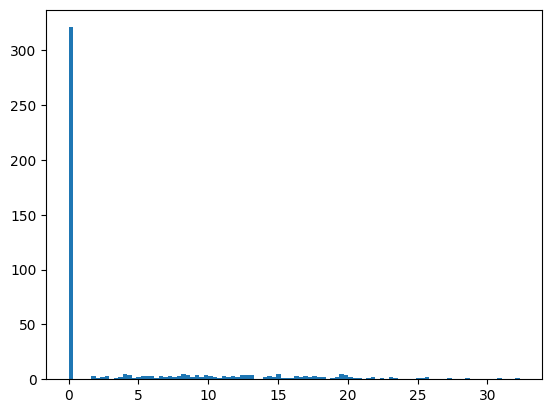

In [32]:
plt.hist((cls_transitions * 2000).values.flatten(), bins=100);

### Renormalize to human genome

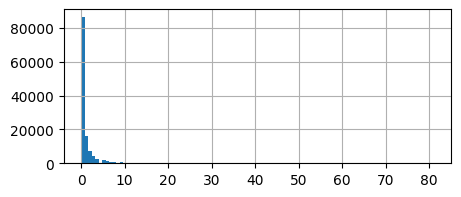

In [17]:
plt.figure(figsize=(5, 2))
species_spectra.Observed.hist(bins=100)
plt.show()

In [20]:
with open("../../signatures/data/codon_counts_GRCh37.json") as fin:
    human_counts = json.load(fin)
    human_counts = {x: human_counts[x] for x in possible_codons}

In [21]:
d = defaultdict(dict)
for triplet, n in human_counts.items():
    if triplet[1] in "CT":
        # print(triplet, n)
        d[triplet]["cosmic"] = n
    else:
        d[rev_comp(triplet)]["other"] = n

d = pd.DataFrame(d).T
d["diff"] = d.cosmic - d.other
d["diff%"] = d["diff"] / d['cosmic']
d

,other,cosmic,diff,diff%
TTT,52955787,53104035,148248,0.002792
GTT,27685307,27789456,104149,0.003748
CTT,39328248,39390888,62640,0.001590
ATT,42582891,42641599,58708,0.001377
ACA,37690444,37558475,-131969,-0.003514
ACC,22396794,22362749,-34045,-0.001522
ACG,5075138,5065207,-9931,-0.001961
ACT,32216082,32173783,-42299,-0.001315
TCT,41895792,41940160,44368,0.001058
GCT,27570880,27581893,11013,0.000399


So, need to use triplets with C & T in 2nd position

In [22]:
multiplier = cls_transitions.index.to_series().apply(lambda x: x[0] + x[2] + x[-1]).map(human_counts)
multiplier

NameError: name 'cls_transitions' is not defined

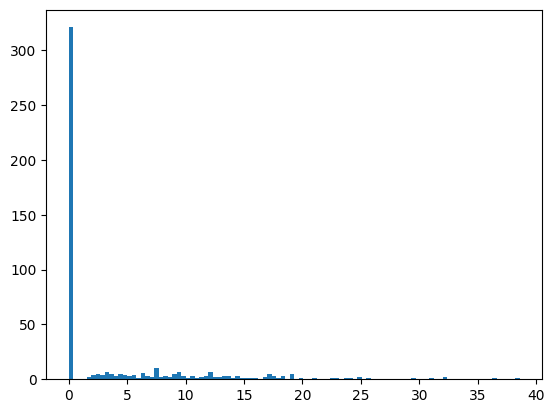

In [34]:
rescaled = (cls_transitions.T * multiplier).T / 1.5e4
plt.hist(rescaled.values.flatten(), bins=100);

In [36]:
rescaled.astype(int).to_csv("../data/decomp/sample2.txt", sep="\t")

### Many variants:

- **low ts** only
- **low ts** + mean tv [(h + l) / 2]
- **high ts** only
- **high ts** + mean tv [(h + l) / 2]
- **high - low** ts only
- **high - low** ts + mean tv [(h + l) / 2]

In [29]:
1 / 1.5e4

6.666666666666667e-05

In [56]:
with open("../../signatures/data/codon_counts_GRCh37.json") as fin:
    human_counts = json.load(fin)
    human_counts = {x: human_counts[x] for x in possible_codons}
    

def save_wide_cls_spectra(df: pd.DataFrame, filename=None, scale_coef=6.6e-5):
    assert df.shape[1] == 96
    df.columns.name = "MutationType"
    multiplier = df.columns.to_series().apply(lambda x: x[0] + x[2] + x[-1]).map(human_counts)
    rescaled = (df * multiplier * scale_coef).T
    rescaled = rescaled.round().astype(int)
    if filename is not None:
        rescaled.sort_index().to_csv(filename, sep="\t")
    return rescaled

In [34]:
species_spectra_wide = complete_sbs_columns(species_spectra.groupby(["Class", "Species", "Mut"]).MutSpec.sum().unstack(), 192)
cls_spectra_wide = species_spectra_wide.mean(level=0)
cls_spectra_wide.head()

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,G[A>C]G,G[A>C]T,T[A>C]A,T[A>C]C,T[A>C]G,T[A>C]T,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,C[A>G]A,C[A>G]C,C[A>G]G,C[A>G]T,G[A>G]A,G[A>G]C,G[A>G]G,G[A>G]T,T[A>G]A,T[A>G]C,T[A>G]G,T[A>G]T,A[A>T]A,A[A>T]C,A[A>T]G,A[A>T]T,C[A>T]A,C[A>T]C,C[A>T]G,C[A>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.000907,0.001506,0.000148,0.0,0.000875,0.003051,0.000520,0.0,0.000653,0.001219,0.001174,0.0,0.000443,0.000553,0.000478,0.0,0.011556,0.014783,0.012066,0.016170,0.008375,0.008921,0.011442,0.012095,0.013335,0.013132,0.017721,0.018911,0.011343,0.010775,0.014338,0.017870,0.001628,0.001842,0.002320,0.0,0.002496,0.002055,0.002493,0.0,...,0.002048,0.000676,0.001258,0.0,0.001748,0.000590,0.000667,0.0,0.005581,0.008418,0.003342,0.006032,0.005052,0.007455,0.003653,0.002931,0.005698,0.006950,0.005497,0.007574,0.003907,0.003070,0.003382,0.003427,0.000863,0.001449,0.001420,0.0,0.000746,0.000531,0.000969,0.0,0.001175,0.001426,0.002098,0.0,0.000556,0.000350,0.001180,0.0
Amphibia,0.000296,0.000000,0.001137,0.0,0.001753,0.001529,0.000326,0.0,0.000109,0.001756,0.003883,0.0,0.000073,0.000000,0.000508,0.0,0.011334,0.010208,0.009538,0.018785,0.007744,0.009792,0.008394,0.011545,0.008999,0.013264,0.018327,0.017759,0.010035,0.010958,0.015043,0.018209,0.005130,0.003796,0.002436,0.0,0.001314,0.001438,0.003655,0.0,...,0.001912,0.001660,0.001686,0.0,0.003071,0.000718,0.001963,0.0,0.006442,0.005304,0.002008,0.005583,0.003578,0.008788,0.002889,0.003408,0.005031,0.003381,0.004458,0.006609,0.002589,0.004307,0.002068,0.001224,0.001838,0.000000,0.001606,0.0,0.000433,0.000960,0.000690,0.0,0.000668,0.002638,0.002041,0.0,0.000589,0.000000,0.002257,0.0
Aves,0.000000,0.000000,0.000890,0.0,0.000000,0.000397,0.000000,0.0,0.000351,0.001192,0.000000,0.0,0.000589,0.000000,0.000704,0.0,0.037541,0.002613,0.030238,0.027339,0.028794,0.011867,0.018250,0.036843,0.029431,0.022981,0.035016,0.034045,0.027648,0.011834,0.018197,0.032987,0.000000,0.000295,0.003617,0.0,0.002797,0.001513,0.003899,0.0,...,0.000911,0.000552,0.000632,0.0,0.000384,0.000689,0.000449,0.0,0.002233,0.002559,0.002694,0.005907,0.002373,0.004108,0.001378,0.000000,0.004106,0.007537,0.002936,0.004404,0.002257,0.001296,0.001113,0.002138,0.001055,0.002156,0.001696,0.0,0.001046,0.000257,0.000547,0.0,0.001860,0.000600,0.000959,0.0,0.000700,0.000288,0.000462,0.0
Lepidosauria,0.000099,0.002130,0.000355,0.0,0.000276,0.000762,0.000000,0.0,0.001004,0.001428,0.001051,0.0,0.000139,0.000000,0.000239,0.0,0.012536,0.023768,0.013822,0.020278,0.014164,0.016008,0.010264,0.017713,0.013944,0.013962,0.030377,0.026956,0.011867,0.010825,0.017715,0.013246,0.001121,0.000502,0.004127,0.0,0.001485,0.000909,0.001251,0.0,...,0.002043,0.000048,0.001027,0.0,0.001154,0.000000,0.000811,0.0,0.002212,0.007131,0.002013,0.007936,0.001982,0.007319,0.001433,0.004700,0.004225,0.007221,0.003959,0.005239,0.000937,0.003773,0.000902,0.000873,0.001273,0.002758,0.001169,0.0,0.000489,0.000602,0.000794,0.0,0.002367,0.003666,0.001290,0.0,0.000979,0.000371,0.000666,0.0
Mammalia,0.000029,0.001598,0.000146,0.0,0.000430,0.000932,0.000811,0.0,0.000697,0.000604,0.000499,0.0,0.000180,0.000292,0.000669,0.0,0.015660,0.017647,0.018496,0.019692,0.012600,0.011361,0.013530,0.018193,0.017964,0.024213,0.023141,0.031363,0.014538,0.014161,0.020737,0.021805,0.001763,0.001227,0.001853,0.0,0.002093,0.003172,0.002401,0.0,...,0.002240,0.000958,0.001170,0.0,0.001249,0.000859,0.000669,0.0,0.002877,0.006247,0.001774,0.004629,0.002528,0.004538,0.001795,0.002770,0.003767,0.004919,0.004083,0.006273,0.002082,0.002601,0.001214,0.001885,0.000482,0.000591,

**Only Ts's**

In [111]:
sbs_low_ts = ["G>A", "T>C"]
low_ts_only = collapse_sbs192(complete_sbs_columns(cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_low_ts]], 192), 96)
save_wide_cls_spectra(low_ts_only, "../data/decomp/low_ts_only.txt")
low_ts_only

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009926,0.006400,0.007295,0.005767,0.008937,0.004126,0.006061,0.003901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005581,0.008418,0.003342,0.006032,0.005052,0.007455,0.003653,0.002931,0.005698,0.006950,0.005497,0.007574,0.003907,0.003070,0.003382,0.003427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015406,0.008083,0.010460,0.008271,0.010229,0.005463,0.008847,0.007567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006442,0.005304,0.002008,0.005583,0.003578,0.008788,0.002889,0.003408,0.005031,0.003381,0.004458,0.006609,0.002589,0.004307,0.002068,0.001224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004919,0.006183,0.010823,0.003571,0.008542,0.004260,0.009779,0.004547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002233,0.002559,0.002694,0.005907,0.002373,0.004108,0.001378,0.000000,0.004106,0.007537,0.002936,0.004404,0.002257,0.001296,0.001113,0.002138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009891,0.007856,0.009818,0.006464,0.008265,0.007694,0.004932,0.005000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002212,0.007131,0.002013,0.007936,0.001982,0.007319,0.001433,0.004700,0.004225,0.007221,0.003959,0.005239,0.000937,0.003773,0.000902,0.000873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012445,0.009792,0.011481,0.008130,0.010967,0.009795,0.010002,0.005855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002877,0.006247,0.001774,0.004629,0.002528,0.004538,0.001795,0.002770,0.003767,0.004919,0.004083,0.006273,0.002082,0.002601,0.001214,0.001885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
sbs_high_ts = ["C>T", "A>G"]
high_ts_only = collapse_sbs192(complete_sbs_columns(cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_high_ts]], 192), 96)
high_ts_only

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034300,0.038927,0.025451,0.015730,0.032613,0.043429,0.033676,0.006414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017870,0.018911,0.012095,0.016170,0.014338,0.017721,0.011442,0.012066,0.010775,0.013132,0.008921,0.014783,0.011343,0.013335,0.008375,0.011556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040563,0.027292,0.035557,0.006143,0.037155,0.051599,0.029648,0.013167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018209,0.017759,0.011545,0.018785,0.015043,0.018327,0.008394,0.009538,0.010958,0.013264,0.009792,0.010208,0.010035,0.008999,0.007744,0.011334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021401,0.025728,0.007470,0.018082,0.030319,0.055830,0.008236,0.004927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032987,0.034045,0.036843,0.027339,0.018197,0.035016,0.018250,0.030238,0.011834,0.022981,0.011867,0.002613,0.027648,0.029431,0.028794,0.037541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027239,0.035401,0.023499,0.021416,0.034822,0.051395,0.006776,0.016375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013246,0.026956,0.017713,0.020278,0.017715,0.030377,0.010264,0.013822,0.010825,0.013962,0.016008,0.023768,0.011867,0.013944,0.014164,0.012536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032653,0.037682,0.020223,0.018949,0.035846,0.042655,0.023792,0.004766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021805,0.031363,0.018193,0.019692,0.020737,0.023141,0.013530,0.018496,0.014161,0.024213,0.011361,0.017647,0.014538,0.017964,0.012600,0.015660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
high_minus_low_ts_only = high_ts_only - low_ts_only
high_minus_low_ts_only[high_minus_low_ts_only < 0] = 0
high_minus_low_ts_only

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024374,0.032527,0.018156,0.009963,0.023676,0.039303,0.027615,0.002513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012290,0.010493,0.008752,0.010139,0.009287,0.010266,0.007788,0.009136,0.005076,0.006182,0.003423,0.007209,0.007436,0.010265,0.004993,0.008130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025157,0.019209,0.025097,0.000000,0.026927,0.046136,0.020801,0.005599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011767,0.012455,0.009536,0.013202,0.011465,0.009539,0.005505,0.006130,0.005927,0.009883,0.005334,0.003598,0.007446,0.004692,0.005676,0.010110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016482,0.019545,0.000000,0.014511,0.021777,0.051570,0.000000,0.000380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030754,0.031486,0.034149,0.021432,0.015823,0.030908,0.016871,0.030238,0.007728,0.015444,0.008931,0.000000,0.025391,0.028135,0.027681,0.035404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017348,0.027545,0.013681,0.014952,0.026558,0.043701,0.001844,0.011374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011034,0.019825,0.015700,0.012342,0.015733,0.023058,0.008831,0.009122,0.006600,0.006741,0.012050,0.018529,0.010930,0.010170,0.013262,0.011663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020208,0.027890,0.008741,0.010819,0.024878,0.032860,0.013790,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018928,0.025116,0.016419,0.015063,0.018208,0.018603,0.011735,0.015727,0.010395,0.019294,0.007277,0.011374,0.012456,0.015363,0.011386,0.013774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Ts's + Tv's**

In [86]:
sbs_tv = ['A>C', 'A>T', 'C>A', 'C>G', 'G>C', 'G>T', 'T>A', 'T>G']
tv_only = collapse_sbs192(complete_sbs_columns(cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_tv]], 192), 96) / 2
tv_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.000494,0.000415,0.000605,0.0,0.002175,0.002067,0.001266,0.000963,0.001715,0.001466,0.001601,0.001892,0.001644,0.001859,0.002584,0.001651,0.001358,0.002331,0.002176,0.0,0.001188,0.001189,0.001240,0.000462,0.002287,0.002687,0.002641,0.000632,0.001260,0.000649,0.001343,0.000533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001912,0.000976,0.001656,0.000921,0.003577,0.001825,0.001581,0.000814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000432,0.000724,0.000710,0.0,0.000612,0.000852,0.000744,0.000074,0.000864,0.001322,0.002575,0.000753,0.000500,0.000502,0.001028,0.000454
Amphibia,0.000000,0.000000,0.000000,0.0,0.003230,0.002523,0.002075,0.001714,0.001443,0.002663,0.001271,0.000494,0.001086,0.000802,0.001627,0.001453,0.003525,0.000411,0.000745,0.0,0.000383,0.001041,0.000787,0.000578,0.000801,0.002104,0.001221,0.000281,0.000389,0.000266,0.000378,0.000092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001124,0.002068,0.001562,0.001898,0.003635,0.001182,0.001639,0.002565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000919,0.000000,0.000803,0.0,0.000471,0.002421,0.000508,0.000569,0.000334,0.002197,0.001785,0.000000,0.000331,0.000055,0.002005,0.000148
Aves,0.000000,0.000000,0.000000,0.0,0.001802,0.001113,0.002174,0.001374,0.002488,0.001670,0.001066,0.002231,0.001356,0.001543,0.004378,0.001629,0.001220,0.000000,0.000183,0.0,0.000486,0.000859,0.000107,0.000358,0.002904,0.000696,0.001400,0.000272,0.000512,0.000227,0.000673,0.000745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000647,0.000659,0.001073,0.000147,0.000912,0.001767,0.001623,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000527,0.001078,0.000848,0.0,0.000875,0.000128,0.000274,0.000445,0.000930,0.000896,0.000678,0.000000,0.000645,0.000320,0.000231,0.000000
Lepidosauria,0.000048,0.000948,0.000798,0.0,0.000942,0.001169,0.001437,0.000871,0.004685,0.001380,0.001922,0.001164,0.001554,0.001925,0.002963,0.002147,0.000733,0.000280,0.001429,0.0,0.000411,0.001567,0.000133,0.000128,0.001466,0.000313,0.000716,0.000251,0.000214,0.000186,0.000911,0.000163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001821,0.000024,0.000968,0.000251,0.002243,0.002080,0.001148,0.000561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000636,0.001379,0.000585,0.0,0.000364,0.000826,0.000397,0.000177,0.001184,0.002547,0.001026,0.001065,0.000559,0.000688,0.000471,0.000050
Mammalia,0.000056,0.000565,0.000018,0.0,0.001286,0.001440,0.001494,0.000968,0.001065,0.001507,0.001101,0.000729,0.001071,0.001398,0.001599,0.001518,0.000445,0.000484,0.000820,0.0,0.000374,0.000584,0.000490,0.000241,0.001085,0.000988,0.000876,0.000415,0.000910,0.000527,0.000593,0.000549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001660,0.000888,0.002171,0.000614,0.002489,0.002436,0.001381,0.000882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000241,0.000295,0.000346,0.0,0.000477,0.000376,0.000587,0.000073,0.000732,0.000866,0.000925,0.000799,0.000238,0.000519,0.000463,0.000015


In [112]:
low_ts_with_tv = tv_only + low_ts_only
save_wide_cls_spectra(low_ts_with_tv, "../data/decomp/low_ts_with_tv.txt")
low_ts_with_tv

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.000494,0.000415,0.000605,0.0,0.002175,0.002067,0.001266,0.000963,0.001715,0.001466,0.001601,0.001892,0.001644,0.001859,0.002584,0.001651,0.001358,0.002331,0.002176,0.0,0.001188,0.001189,0.001240,0.000462,0.002287,0.002687,0.002641,0.000632,0.001260,0.000649,0.001343,0.000533,0.009926,0.006400,0.007295,0.005767,0.008937,0.004126,0.006061,0.003901,...,0.001912,0.000976,0.001656,0.000921,0.003577,0.001825,0.001581,0.000814,0.005581,0.008418,0.003342,0.006032,0.005052,0.007455,0.003653,0.002931,0.005698,0.006950,0.005497,0.007574,0.003907,0.003070,0.003382,0.003427,0.000432,0.000724,0.000710,0.0,0.000612,0.000852,0.000744,0.000074,0.000864,0.001322,0.002575,0.000753,0.000500,0.000502,0.001028,0.000454
Amphibia,0.000000,0.000000,0.000000,0.0,0.003230,0.002523,0.002075,0.001714,0.001443,0.002663,0.001271,0.000494,0.001086,0.000802,0.001627,0.001453,0.003525,0.000411,0.000745,0.0,0.000383,0.001041,0.000787,0.000578,0.000801,0.002104,0.001221,0.000281,0.000389,0.000266,0.000378,0.000092,0.015406,0.008083,0.010460,0.008271,0.010229,0.005463,0.008847,0.007567,...,0.001124,0.002068,0.001562,0.001898,0.003635,0.001182,0.001639,0.002565,0.006442,0.005304,0.002008,0.005583,0.003578,0.008788,0.002889,0.003408,0.005031,0.003381,0.004458,0.006609,0.002589,0.004307,0.002068,0.001224,0.000919,0.000000,0.000803,0.0,0.000471,0.002421,0.000508,0.000569,0.000334,0.002197,0.001785,0.000000,0.000331,0.000055,0.002005,0.000148
Aves,0.000000,0.000000,0.000000,0.0,0.001802,0.001113,0.002174,0.001374,0.002488,0.001670,0.001066,0.002231,0.001356,0.001543,0.004378,0.001629,0.001220,0.000000,0.000183,0.0,0.000486,0.000859,0.000107,0.000358,0.002904,0.000696,0.001400,0.000272,0.000512,0.000227,0.000673,0.000745,0.004919,0.006183,0.010823,0.003571,0.008542,0.004260,0.009779,0.004547,...,0.000647,0.000659,0.001073,0.000147,0.000912,0.001767,0.001623,0.000000,0.002233,0.002559,0.002694,0.005907,0.002373,0.004108,0.001378,0.000000,0.004106,0.007537,0.002936,0.004404,0.002257,0.001296,0.001113,0.002138,0.000527,0.001078,0.000848,0.0,0.000875,0.000128,0.000274,0.000445,0.000930,0.000896,0.000678,0.000000,0.000645,0.000320,0.000231,0.000000
Lepidosauria,0.000048,0.000948,0.000798,0.0,0.000942,0.001169,0.001437,0.000871,0.004685,0.001380,0.001922,0.001164,0.001554,0.001925,0.002963,0.002147,0.000733,0.000280,0.001429,0.0,0.000411,0.001567,0.000133,0.000128,0.001466,0.000313,0.000716,0.000251,0.000214,0.000186,0.000911,0.000163,0.009891,0.007856,0.009818,0.006464,0.008265,0.007694,0.004932,0.005000,...,0.001821,0.000024,0.000968,0.000251,0.002243,0.002080,0.001148,0.000561,0.002212,0.007131,0.002013,0.007936,0.001982,0.007319,0.001433,0.004700,0.004225,0.007221,0.003959,0.005239,0.000937,0.003773,0.000902,0.000873,0.000636,0.001379,0.000585,0.0,0.000364,0.000826,0.000397,0.000177,0.001184,0.002547,0.001026,0.001065,0.000559,0.000688,0.000471,0.000050
Mammalia,0.000056,0.000565,0.000018,0.0,0.001286,0.001440,0.001494,0.000968,0.001065,0.001507,0.001101,0.000729,0.001071,0.001398,0.001599,0.001518,0.000445,0.000484,0.000820,0.0,0.000374,0.000584,0.000490,0.000241,0.001085,0.000988,0.000876,0.000415,0.000910,0.000527,0.000593,0.000549,0.012445,0.009792,0.011481,0.008130,0.010967,0.009795,0.010002,0.005855,...,0.001660,0.0008

In [94]:
high_ts_with_tv = tv_only + high_ts_only
high_ts_with_tv

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.000494,0.000415,0.000605,0.0,0.002175,0.002067,0.001266,0.000963,0.001715,0.001466,0.001601,0.001892,0.001644,0.001859,0.002584,0.001651,0.001358,0.002331,0.002176,0.0,0.001188,0.001189,0.001240,0.000462,0.002287,0.002687,0.002641,0.000632,0.001260,0.000649,0.001343,0.000533,0.034300,0.038927,0.025451,0.015730,0.032613,0.043429,0.033676,0.006414,...,0.001912,0.000976,0.001656,0.000921,0.003577,0.001825,0.001581,0.000814,0.017870,0.018911,0.012095,0.016170,0.014338,0.017721,0.011442,0.012066,0.010775,0.013132,0.008921,0.014783,0.011343,0.013335,0.008375,0.011556,0.000432,0.000724,0.000710,0.0,0.000612,0.000852,0.000744,0.000074,0.000864,0.001322,0.002575,0.000753,0.000500,0.000502,0.001028,0.000454
Amphibia,0.000000,0.000000,0.000000,0.0,0.003230,0.002523,0.002075,0.001714,0.001443,0.002663,0.001271,0.000494,0.001086,0.000802,0.001627,0.001453,0.003525,0.000411,0.000745,0.0,0.000383,0.001041,0.000787,0.000578,0.000801,0.002104,0.001221,0.000281,0.000389,0.000266,0.000378,0.000092,0.040563,0.027292,0.035557,0.006143,0.037155,0.051599,0.029648,0.013167,...,0.001124,0.002068,0.001562,0.001898,0.003635,0.001182,0.001639,0.002565,0.018209,0.017759,0.011545,0.018785,0.015043,0.018327,0.008394,0.009538,0.010958,0.013264,0.009792,0.010208,0.010035,0.008999,0.007744,0.011334,0.000919,0.000000,0.000803,0.0,0.000471,0.002421,0.000508,0.000569,0.000334,0.002197,0.001785,0.000000,0.000331,0.000055,0.002005,0.000148
Aves,0.000000,0.000000,0.000000,0.0,0.001802,0.001113,0.002174,0.001374,0.002488,0.001670,0.001066,0.002231,0.001356,0.001543,0.004378,0.001629,0.001220,0.000000,0.000183,0.0,0.000486,0.000859,0.000107,0.000358,0.002904,0.000696,0.001400,0.000272,0.000512,0.000227,0.000673,0.000745,0.021401,0.025728,0.007470,0.018082,0.030319,0.055830,0.008236,0.004927,...,0.000647,0.000659,0.001073,0.000147,0.000912,0.001767,0.001623,0.000000,0.032987,0.034045,0.036843,0.027339,0.018197,0.035016,0.018250,0.030238,0.011834,0.022981,0.011867,0.002613,0.027648,0.029431,0.028794,0.037541,0.000527,0.001078,0.000848,0.0,0.000875,0.000128,0.000274,0.000445,0.000930,0.000896,0.000678,0.000000,0.000645,0.000320,0.000231,0.000000
Lepidosauria,0.000048,0.000948,0.000798,0.0,0.000942,0.001169,0.001437,0.000871,0.004685,0.001380,0.001922,0.001164,0.001554,0.001925,0.002963,0.002147,0.000733,0.000280,0.001429,0.0,0.000411,0.001567,0.000133,0.000128,0.001466,0.000313,0.000716,0.000251,0.000214,0.000186,0.000911,0.000163,0.027239,0.035401,0.023499,0.021416,0.034822,0.051395,0.006776,0.016375,...,0.001821,0.000024,0.000968,0.000251,0.002243,0.002080,0.001148,0.000561,0.013246,0.026956,0.017713,0.020278,0.017715,0.030377,0.010264,0.013822,0.010825,0.013962,0.016008,0.023768,0.011867,0.013944,0.014164,0.012536,0.000636,0.001379,0.000585,0.0,0.000364,0.000826,0.000397,0.000177,0.001184,0.002547,0.001026,0.001065,0.000559,0.000688,0.000471,0.000050
Mammalia,0.000056,0.000565,0.000018,0.0,0.001286,0.001440,0.001494,0.000968,0.001065,0.001507,0.001101,0.000729,0.001071,0.001398,0.001599,0.001518,0.000445,0.000484,0.000820,0.0,0.000374,0.000584,0.000490,0.000241,0.001085,0.000988,0.000876,0.000415,0.000910,0.000527,0.000593,0.000549,0.032653,0.037682,0.020223,0.018949,0.035846,0.042655,0.023792,0.004766,...,0.001660,0.0008

In [95]:
high_minus_low_ts_with_tv = tv_only + high_minus_low_ts_only
high_minus_low_ts_with_tv

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,...,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actinopterygii,0.000494,0.000415,0.000605,0.0,0.002175,0.002067,0.001266,0.000963,0.001715,0.001466,0.001601,0.001892,0.001644,0.001859,0.002584,0.001651,0.001358,0.002331,0.002176,0.0,0.001188,0.001189,0.001240,0.000462,0.002287,0.002687,0.002641,0.000632,0.001260,0.000649,0.001343,0.000533,0.024374,0.032527,0.018156,0.009963,0.023676,0.039303,0.027615,0.002513,...,0.001912,0.000976,0.001656,0.000921,0.003577,0.001825,0.001581,0.000814,0.012290,0.010493,0.008752,0.010139,0.009287,0.010266,0.007788,0.009136,0.005076,0.006182,0.003423,0.007209,0.007436,0.010265,0.004993,0.008130,0.000432,0.000724,0.000710,0.0,0.000612,0.000852,0.000744,0.000074,0.000864,0.001322,0.002575,0.000753,0.000500,0.000502,0.001028,0.000454
Amphibia,0.000000,0.000000,0.000000,0.0,0.003230,0.002523,0.002075,0.001714,0.001443,0.002663,0.001271,0.000494,0.001086,0.000802,0.001627,0.001453,0.003525,0.000411,0.000745,0.0,0.000383,0.001041,0.000787,0.000578,0.000801,0.002104,0.001221,0.000281,0.000389,0.000266,0.000378,0.000092,0.025157,0.019209,0.025097,0.000000,0.026927,0.046136,0.020801,0.005599,...,0.001124,0.002068,0.001562,0.001898,0.003635,0.001182,0.001639,0.002565,0.011767,0.012455,0.009536,0.013202,0.011465,0.009539,0.005505,0.006130,0.005927,0.009883,0.005334,0.003598,0.007446,0.004692,0.005676,0.010110,0.000919,0.000000,0.000803,0.0,0.000471,0.002421,0.000508,0.000569,0.000334,0.002197,0.001785,0.000000,0.000331,0.000055,0.002005,0.000148
Aves,0.000000,0.000000,0.000000,0.0,0.001802,0.001113,0.002174,0.001374,0.002488,0.001670,0.001066,0.002231,0.001356,0.001543,0.004378,0.001629,0.001220,0.000000,0.000183,0.0,0.000486,0.000859,0.000107,0.000358,0.002904,0.000696,0.001400,0.000272,0.000512,0.000227,0.000673,0.000745,0.016482,0.019545,0.000000,0.014511,0.021777,0.051570,0.000000,0.000380,...,0.000647,0.000659,0.001073,0.000147,0.000912,0.001767,0.001623,0.000000,0.030754,0.031486,0.034149,0.021432,0.015823,0.030908,0.016871,0.030238,0.007728,0.015444,0.008931,0.000000,0.025391,0.028135,0.027681,0.035404,0.000527,0.001078,0.000848,0.0,0.000875,0.000128,0.000274,0.000445,0.000930,0.000896,0.000678,0.000000,0.000645,0.000320,0.000231,0.000000
Lepidosauria,0.000048,0.000948,0.000798,0.0,0.000942,0.001169,0.001437,0.000871,0.004685,0.001380,0.001922,0.001164,0.001554,0.001925,0.002963,0.002147,0.000733,0.000280,0.001429,0.0,0.000411,0.001567,0.000133,0.000128,0.001466,0.000313,0.000716,0.000251,0.000214,0.000186,0.000911,0.000163,0.017348,0.027545,0.013681,0.014952,0.026558,0.043701,0.001844,0.011374,...,0.001821,0.000024,0.000968,0.000251,0.002243,0.002080,0.001148,0.000561,0.011034,0.019825,0.015700,0.012342,0.015733,0.023058,0.008831,0.009122,0.006600,0.006741,0.012050,0.018529,0.010930,0.010170,0.013262,0.011663,0.000636,0.001379,0.000585,0.0,0.000364,0.000826,0.000397,0.000177,0.001184,0.002547,0.001026,0.001065,0.000559,0.000688,0.000471,0.000050
Mammalia,0.000056,0.000565,0.000018,0.0,0.001286,0.001440,0.001494,0.000968,0.001065,0.001507,0.001101,0.000729,0.001071,0.001398,0.001599,0.001518,0.000445,0.000484,0.000820,0.0,0.000374,0.000584,0.000490,0.000241,0.001085,0.000988,0.000876,0.000415,0.000910,0.000527,0.000593,0.000549,0.020208,0.027890,0.008741,0.010819,0.024878,0.032860,0.013790,0.000000,...,0.001660,0.0008

Concatenate pairwise all 6 variants

In [106]:
d = []
for x, _lbl in zip(
    [low_ts_only, low_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra(total_samples, "../data/decomp/low_Ts_samples.txt")


d = []
for x, _lbl in zip(
    [high_ts_only, high_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra(total_samples, "../data/decomp/high_Ts_samples.txt")


d = []
for x, _lbl in zip(
    [high_minus_low_ts_only, high_minus_low_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra(total_samples, "../data/decomp/high_minus_low_Ts_samples.txt")

,Actinopterygii__Ts only,Amphibia__Ts only,Aves__Ts only,Lepidosauria__Ts only,Mammalia__Ts only,Actinopterygii__Ts & Tv,Amphibia__Ts & Tv,Aves__Ts & Tv,Lepidosauria__Ts & Tv,Mammalia__Ts & Tv
MutationType,,,,,,,,,,
A[C>A]A,0,0,0,0,0,1,0,0,0,0
A[C>A]C,0,0,0,0,0,1,0,0,1,1
A[C>A]G,0,0,0,0,0,0,0,0,0,0
A[C>A]T,0,0,0,0,0,0,0,0,0,0
C[C>A]A,0,0,0,0,0,5,7,4,2,3
...,...,...,...,...,...,...,...,...,...,...
G[T>G]T,0,0,0,0,0,1,0,0,2,1
T[T>G]A,0,0,0,0,0,1,1,2,1,1
T[T>G]C,0,0,0,0,0,1,0,1,2,1


In [145]:
save_wide_cls_spectra(collapse_sbs192(cls_spectra_wide, 96), "../data/decomp/simple_96_saples.txt")

Class,Actinopterygii,Amphibia,Aves,Lepidosauria,Mammalia
MutationType,,,,,
A[C>A]A,2,0,0,0,0
A[C>A]C,1,0,0,3,2
A[C>A]G,0,0,0,1,0
A[C>A]T,0,0,0,0,0
C[C>A]A,10,15,8,4,6
...,...,...,...,...,...
G[T>G]T,3,0,0,4,3
T[T>G]A,2,2,3,3,1
T[T>G]C,2,0,2,3,3


# Results

## Test on low_ts_only

### Round 1. Simplified emulation of human nuclear mutations without renormalization

In [68]:
samples = "../data/decomp/sample1.txt"
output = "../data/decomp/try1/"

exclude_signature_subgroups = [
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'AA_signatures',
    'Colibactin_signatures',
    'Artifact_signatures',
    'Lymphoid_signatures',
]

Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                   collapse_to_SBS96=True, cosmic_version=3.3, exome=False,
                   signature_database=None,
                   exclude_signature_subgroups=exclude_signature_subgroups, 
                   export_probabilities=True,
                   export_probabilities_per_mutation=False, make_plots=True,
                   sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 5/5 [100%] in 0.3s (14.70/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


Another rough result (need to carefully setup SigProfiller before execution on mito-spectra):

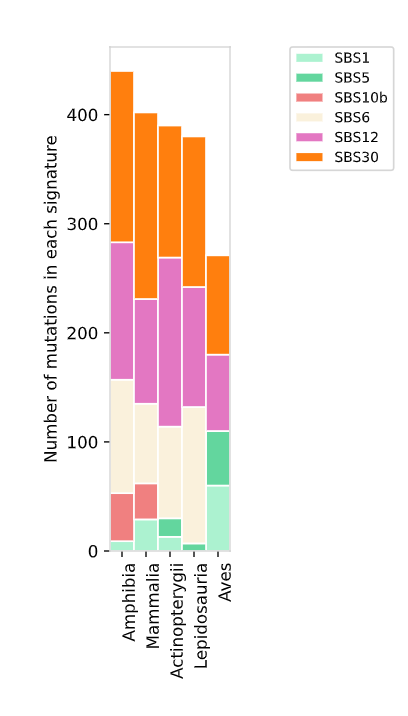

In [77]:
print("Main signatures:")
for x in ["SBS30", "SBS12", "SBS6"]:
    print(f"  {x} - {sbs2effect.get(x, 'UNK')}")

Main signatures:
  SBS30 - BER_deficiency
  SBS12 - UNK
  SBS6 - MMR_deficiency


In [70]:
pd.read_csv("../data/decomp/try1/Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')

,Sample Names,Total Mutations,Cosine Similarity,L1 Norm,L1_Norm_%,L2 Norm,L2_Norm_%,KL Divergence,Correlation
0,Actinopterygii,390,0.913,165.266,42.376%,30.409,40.855%,0.18604,0.875
1,Amphibia,440,0.951,147.398,33.5%,27.526,30.957%,0.15007,0.935
2,Aves,271,0.908,139.931,51.635%,23.422,41.925%,0.26717,0.876
3,Lepidosauria,380,0.918,170.415,44.846%,30.606,39.691%,0.21004,0.889
4,Mammalia,402,0.962,122.833,30.555%,22.413,27.288%,0.14062,0.949


### Round 2. Emulation of human nuclear mutations WITH renormalization

In [12]:
from SigProfilerAssignment import Analyzer as Analyze

samples = "../data/decomp/sample2.txt"
output = "../data/decomp/try2/"

exclude_signature_subgroups = [
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'AA_signatures',
    'Colibactin_signatures',
    'Artifact_signatures',
    'Lymphoid_signatures',
]

Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                   cosmic_version=3.3, exome=False,
                   nnls_remove_penalty=0.01, nnls_add_penalty = 0.01,
                   exclude_signature_subgroups=exclude_signature_subgroups, 
                   export_probabilities=True, make_plots=True,
                   sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 5/5 [100%] in 0.7s (7.63/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


Another rough result (need to carefully setup SigProfiller before execution on mito-spectra):

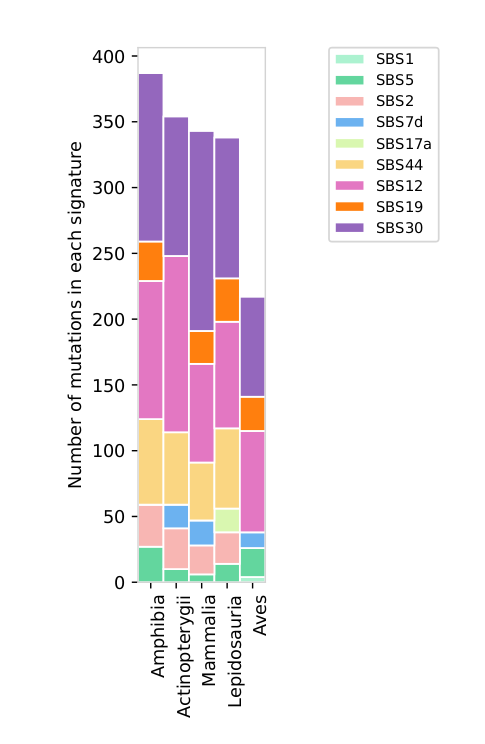

In [14]:
print("Main signatures:")
for x in ["SBS30", "SBS19", "SBS12", "SBS44", "SBS5"]:
    print(f"  {x} - {sbs2effect.get(x, 'UNK')}")

Main signatures:
  SBS30 - BER_deficiency
  SBS19 - UNK
  SBS12 - UNK
  SBS44 - MMR_deficiency
  SBS5 - UNK_clock_like


In [13]:
import pandas as pd
pd.read_csv("../data/decomp/try2/Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')

,Sample Names,Total Mutations,Cosine Similarity,L1 Norm,L1_Norm_%,L2 Norm,L2_Norm_%,KL Divergence,Correlation
0,Actinopterygii,354,0.938,150.351,42.472%,25.596,35.272%,0.19825,0.918
1,Amphibia,387,0.934,169.726,43.857%,31.023,36.743%,0.21563,0.917
2,Aves,217,0.922,91.244,42.048%,17.710,39.414%,0.22095,0.898
3,Lepidosauria,338,0.914,165.618,48.999%,30.013,41.164%,0.26649,0.889
4,Mammalia,343,0.959,122.433,35.695%,21.870,29.067%,0.16890,0.948


## Round 3: Total variants

In [129]:
from SigProfilerAssignment import Analyzer as Analyze

samples_pattern = "../data/decomp/{}_samples.txt"
output_pattern = "../data/decomp/{}/"

exclude_signature_subgroups = [
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'AA_signatures',
    'Colibactin_signatures',
    'Artifact_signatures',
    'Lymphoid_signatures',
]

for label in ["low_Ts", "high_Ts", "high_minus_low_Ts"]:
    samples = samples_pattern.format(label)
    output  = output_pattern.format(label)
    Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                    cosmic_version=3.3, exome=False,
                    nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
                    exclude_signature_subgroups=exclude_signature_subgroups, 
                    export_probabilities=False, make_plots=True,
                    sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 0.9s (10.60/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 0.7s (14.71/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88

In [108]:
pd.read_csv("../data/decomp/low_Ts/Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')

,Sample Names,Total Mutations,Cosine Similarity,L1 Norm,L1_Norm_%,L2 Norm,L2_Norm_%,KL Divergence,Correlation
0,Actinopterygii__Ts only,369,0.942,146.041,39.578%,25.411,34.021%,0.17568,0.923
1,Amphibia__Ts only,401,0.937,175.601,43.791%,31.156,36.065%,0.21584,0.921
2,Aves__Ts only,228,0.918,95.694,41.971%,18.903,40.301%,0.22760,0.892
3,Lepidosauria__Ts only,348,0.917,169.614,48.74%,30.286,40.595%,0.26530,0.892
4,Mammalia__Ts only,355,0.960,124.345,35.027%,21.934,28.714%,0.16883,0.949
5,Actinopterygii__Ts & Tv,503,0.941,180.099,35.805%,26.403,33.953%,0.13836,0.895
6,Amphibia__Ts & Tv,536,0.932,234.099,43.675%,32.709,36.379%,0.20581,0.889
7,Aves__Ts & Tv,322,0.892,166.077,51.577%,22.789,45.615%,0.27066,0.802
8,Lepidosauria__Ts & Tv,446,0.911,223.414,50.093%,31.795,41.352%,0.25981,0.859
9,Mammalia__Ts & Tv,448,0.960,149.636,33.401%,21.739,27.848%,0.13814,0.939


In [109]:
pd.read_csv("../data/decomp/high_Ts/Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')

,Sample Names,Total Mutations,Cosine Similarity,L1 Norm,L1_Norm_%,L2 Norm,L2_Norm_%,KL Divergence,Correlation
0,Actinopterygii__Ts only,1166,0.930,519.433,44.548%,91.066,37.426%,0.19543,0.908
1,Amphibia__Ts only,1151,0.931,485.786,42.206%,92.821,37.166%,0.17378,0.912
2,Aves__Ts only,1577,0.889,855.348,54.239%,154.330,46.33%,0.27842,0.855
3,Lepidosauria__Ts only,1252,0.899,596.823,47.67%,113.374,43.958%,0.21378,0.865
4,Mammalia__Ts only,1314,0.920,590.982,44.976%,104.326,39.412%,0.20209,0.892
5,Actinopterygii__Ts & Tv,1300,0.933,486.074,37.39%,87.744,35.919%,0.12187,0.904
6,Amphibia__Ts & Tv,1286,0.933,496.446,38.604%,90.350,35.998%,0.13256,0.907
7,Aves__Ts & Tv,1671,0.887,830.124,49.678%,155.034,46.48%,0.23247,0.845
8,Lepidosauria__Ts & Tv,1350,0.901,582.586,43.155%,112.129,43.363%,0.17066,0.859
9,Mammalia__Ts & Tv,1407,0.923,552.011,39.233%,102.082,38.494%,0.13859,0.889


In [110]:
pd.read_csv("../data/decomp/high_minus_low_Ts/Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')

,Sample Names,Total Mutations,Cosine Similarity,L1 Norm,L1_Norm_%,L2 Norm,L2_Norm_%,KL Divergence,Correlation
0,Actinopterygii__Ts only,799,0.896,405.155,50.708%,78.483,44.828%,0.24484,0.867
1,Amphibia__Ts only,759,0.887,394.945,52.035%,80.684,46.618%,0.24020,0.858
2,Aves__Ts only,1356,0.869,799.427,58.955%,148.867,50.035%,0.33632,0.832
3,Lepidosauria__Ts only,912,0.874,490.648,53.799%,95.406,48.902%,0.26486,0.834
4,Mammalia__Ts only,962,0.900,484.399,50.353%,87.291,44.117%,0.26017,0.866
5,Actinopterygii__Ts & Tv,933,0.900,397.002,42.551%,76.822,43.548%,0.16683,0.856
6,Amphibia__Ts & Tv,894,0.887,434.724,48.627%,80.844,46.234%,0.21439,0.840
7,Aves__Ts & Tv,1450,0.867,775.292,53.468%,149.546,50.18%,0.28666,0.820
8,Lepidosauria__Ts & Tv,1010,0.875,482.756,47.798%,94.920,48.434%,0.23103,0.823
9,Mammalia__Ts & Tv,1055,0.904,455.155,43.143%,85.058,42.847%,0.18156,0.861


In [127]:
from SigProfilerAssignment import Analyzer as Analyze

samples = "../data/decomp/low_ts_only.txt"
output = "../data/decomp/low_ts_only/"

Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                cosmic_version=3.3, exome=False,
                nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
                exclude_signature_subgroups=exclude_signature_subgroups, 
                export_probabilities=False, make_plots=True,
                sample_reconstruction_plots=True, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 5/5 [100%] in 0.4s (11.87/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


In [128]:
from SigProfilerAssignment import Analyzer as Analyze

samples = "../data/decomp/low_ts_with_tv.txt"
output = "../data/decomp/low_ts_with_tv/"

Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                cosmic_version=3.3, exome=False,
                nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
                exclude_signature_subgroups=exclude_signature_subgroups, 
                export_probabilities=False, make_plots=True,
                sample_reconstruction_plots=True, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 5/5 [100%] in 0.5s (10.13/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


In [146]:
from SigProfilerAssignment import Analyzer as Analyze

samples = "../data/decomp/simple_96_saples.txt"
output = "../data/decomp/simple_96_saples/"

Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                cosmic_version=3.3, exome=False,
                nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
                exclude_signature_subgroups=exclude_signature_subgroups, 
                export_probabilities=False, make_plots=True,
                sample_reconstruction_plots=True, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 5/5 [100%] in 0.4s (12.18/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


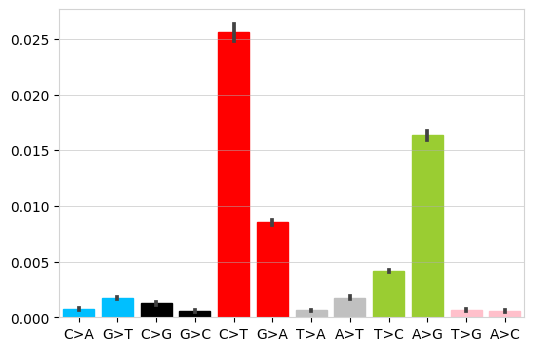

<AxesSubplot:>

In [140]:
plot_mutspec12(species_spectra.copy().drop("Mut", axis=1).rename(columns={"sbs12h":"Mut"}), title="")

## Make beautiful images and add them to single panel
in the scpipt [plotActivity.py](./plotActivity.py)

# Legacy (BE)

## C>T (light) similarity to COSMIC
1. cosine similarity with ALL cosmic signatures for 16 bins of GH>AH == CL>TL. Of course we have to compare it with C>T in cosmic, but before we need to reverse complement all 16 GH>AH.

In [ ]:
cls_spectra[cls_spectra.sbs12l == "C>T"].head()

,Class,sbs192h,MutSpec,sbs12h,sbs12l,sbs192l
24,Actinopterygii,A[G>A]A,0.006024,G>A,C>T,T[C>T]T
25,Actinopterygii,A[G>A]C,0.006952,G>A,C>T,G[C>T]T
26,Actinopterygii,A[G>A]G,0.003830,G>A,C>T,C[C>T]T
27,Actinopterygii,A[G>A]T,0.005455,G>A,C>T,A[C>T]T
72,Actinopterygii,C[G>A]A,0.009724,G>A,C>T,T[C>T]G


In [ ]:
data = []
for cls_name, gr in cls_spectra[cls_spectra.sbs12l == "C>T"].groupby("Class"):
    cosm_subset = cosmic96.loc[gr.sbs192l]
    for col in cosm_subset.columns:
        cos_dist = spatial.distance.cosine(cosm_subset[col], gr.MutSpec)
        data.append({
            "Class": cls_name,
            "COSMIC": col,
            "CosSim": 1 - cos_dist,
        })

similarities_ct_light = pd.DataFrame(data).pivot("Class", "COSMIC", "CosSim").T\
    .sort_values(['Mammalia', 'Aves','Actinopterygii', 'Amphibia', 'Lepidosauria'], ascending=False)

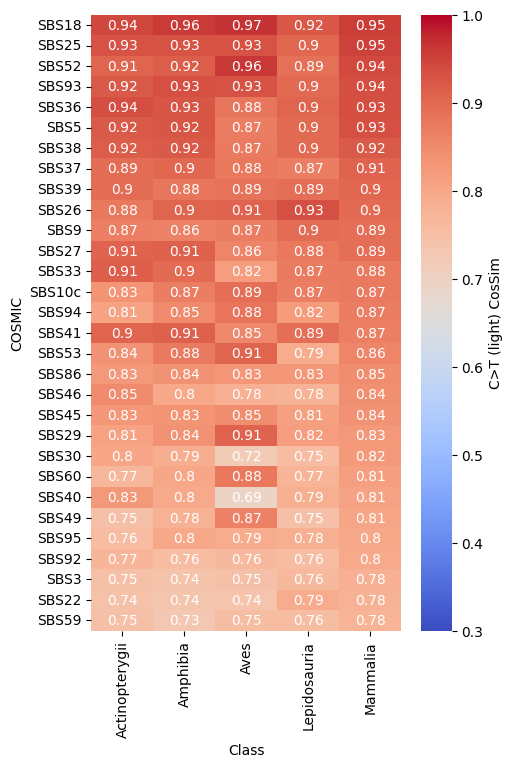

In [ ]:
plt.figure(figsize=(5, 8))
sns.heatmap(similarities_ct_light.head(30), annot=True, vmax=1, vmin=0.3, cmap="coolwarm", cbar_kws={"label": "C>T (light) CosSim"}, annot_kws={"color":"w"})
plt.show()

In [ ]:
similarities_ct_light["Effect"] = similarities_ct_light.index.map(sbs2effect)

In [ ]:
print(similarities_ct_light.round(2).head(20))

Class   Actinopterygii  Amphibia  Aves  Lepidosauria  Mammalia          Effect
COSMIC                                                                        
SBS18             0.94      0.96  0.97          0.92      0.95             ROS
SBS25             0.93      0.93  0.93          0.90      0.95       Treatment
SBS52             0.91      0.92  0.96          0.89      0.94        Artifact
SBS93             0.92      0.93  0.93          0.90      0.94             NaN
SBS36             0.94      0.93  0.88          0.90      0.93  BER_deficiency
SBS5              0.92      0.92  0.87          0.90      0.93             NaN
SBS38             0.92      0.92  0.87          0.90      0.92              UV
SBS37             0.89      0.90  0.88          0.87      0.91             NaN
SBS39             0.90      0.88  0.89          0.89      0.90             NaN
SBS26             0.88      0.90  0.91          0.93      0.90  MMR_deficiency
SBS9              0.87      0.86  0.87          0.90

## H - L
we want to get cosine similarity for all single-strand specific mutations (asymmetric ones), which we can get as heavy chain mutations minus light
strand mutations (we subtract reverse complement equivalent motivs, for example CCC>CTC on heavy strand - GGG>GAG on light strand). Finally we will get 96 numbers (minus some NA) which is good to have in terms of COSMIC (6 base substitution).
<!-- ```
Gh>Th - Gl>Tl (Ch>Ah)
Ch>Gh - Cl>Gl (Gh>Ch)
Ch>Th - Cl>Tl (Gh>Ah)
Ah>Th - Al>Tl (Th>Ah)
Ah>Gh - Al>Gl (Th>Ch)
Th>Gh - Tl>Gl (Ah>Ch)
``` -->

In [ ]:
# sbs6_main = ["G>T", "C>G", "C>T", "A>T", "A>G", "T>G"]
sbs6_main = cosmic.index.str.slice(2,5).unique().values
sbs6_main

array(['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G'], dtype=object)

In [ ]:
cls_spectra_heavy = cls_spectra[cls_spectra.sbs12h.isin(sbs6_main)].rename(columns={"sbs192h": "sbs96", "sbs12h": "sbs6"}).drop(["sbs192l", "sbs12l"], axis=1)
cls_spectra_light = cls_spectra[cls_spectra.sbs12l.isin(sbs6_main)].rename(columns={"sbs192l": "sbs96", "sbs12l": "sbs6"}).drop(["sbs192h", "sbs12h"], axis=1)

In [ ]:
cls_spectra96 = cls_spectra_heavy.merge(cls_spectra_light.drop("sbs6", axis=1), on=["Class", "sbs96"], suffixes=["_h", "_l"])
cls_spectra96["Diff"] = cls_spectra96.MutSpec_h - cls_spectra96.MutSpec_l
cls_spectra96.head()

,Class,sbs96,MutSpec_h,sbs6,MutSpec_l,Diff
0,Actinopterygii,A[C>A]A,0.000786,C>A,0.0,0.000786
1,Actinopterygii,A[C>A]C,0.001114,C>A,0.0,0.001114
2,Actinopterygii,A[C>A]G,0.001247,C>A,0.0,0.001247
3,Actinopterygii,A[C>A]T,0.000000,C>A,0.0,0.000000
4,Actinopterygii,A[C>G]A,0.003199,C>G,0.0,0.003199


Some values are **negative** bacause values on light strand for some substitutions ware greater

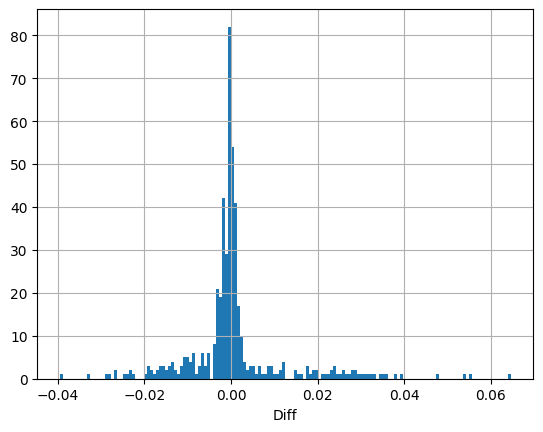

In [ ]:
cls_spectra96.Diff.hist(bins=150)
plt.xlabel("Diff");

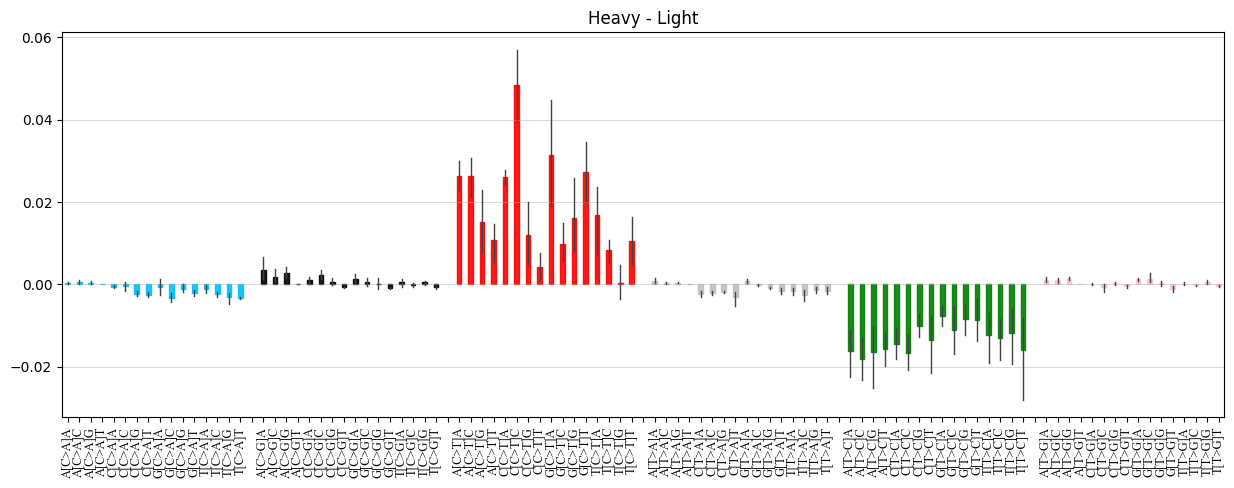

In [ ]:
plot_mutspec96(cls_spectra96.rename(columns={"sbs96": "Mut"}), "Diff", "Heavy - Light")

In [ ]:
data2 = []
for cls_name, gr in cls_spectra96.groupby("Class"):
    cosm_subset = cosmic96.loc[gr.sbs96]
    for col in cosm_subset.columns:
        cos_dist = spatial.distance.cosine(cosm_subset[col], gr.MutSpec)
        data2.append({
            "Class": cls_name,
            "COSMIC": col,
            "CosSim": 1 - cos_dist,
        })

similarities_diff_light = pd.DataFrame(data2).pivot("Class", "COSMIC", "CosSim").T\
    .sort_values(['Mammalia', 'Aves','Actinopterygii', 'Amphibia', 'Lepidosauria'], ascending=False)

In [ ]:
gr

,Class,sbs96,MutSpec_h,sbs6,MutSpec_l,Diff
0,Actinopterygii,A[A>G]A,0.010700,A>G,0.004133,0.006568
1,Actinopterygii,A[A>G]C,0.014734,A>G,0.007639,0.007096
2,Actinopterygii,A[A>G]G,0.011472,A>G,0.003063,0.008408
3,Actinopterygii,A[A>G]T,0.014797,A>G,0.006446,0.008351
4,Actinopterygii,A[A>T]A,0.001568,A>T,0.000000,0.001568
...,...,...,...,...,...,...
91,Actinopterygii,T[G>T]T,0.000000,G>T,0.000786,-0.000786
92,Actinopterygii,T[T>G]A,0.000537,T>G,0.000527,0.000010
93,Actinopterygii,T[T>G]C,0.000333,T>G,0.000569,-0.000236
94,Actinopterygii,T[T>G]G,0.001069,T>G,0.000747,0.000321


In [ ]:
similarities_diff_light.head(10)

In [ ]:
plt.figure(figsize=(5, 8))
sns.heatmap(similarities_diff_light.head(30), annot=True, vmax=1, vmin=0.3, cmap="coolwarm", cbar_kws={"label": "C>T (light) CosSim"}, annot_kws={"color":"w"})
plt.show()

# Make SuplFile2 with mutspec of all verte3brate classes add. whole mutspec for vertebrates 

### Download mutspec of vertebrates, SBS cosmic data and cancer mutspec 


In [68]:
mut_vert = pd.read_csv('../data/MutSpecVertebratescytb.csv')
cosm_sbs = pd.read_table('../data/external/COSMIC_v3.3.1_SBS_GRCh37.txt')
canc_df = pd.read_csv('../data/external/cancer_mutspec.csv')


In [69]:
canc_df = canc_df[['Mut','MutSpec_ExDloop']]
canc_df = canc_df.rename(columns={"MutSpec_ExDloop":"Cancers"})
canc_df.head()

,Mut,Cancers
0,A[A>C]A,0.000000
1,A[A>C]C,0.000783
2,A[A>C]G,0.000000
3,A[A>C]T,0.000084
4,A[A>G]A,0.008273


### Look at cosmic and mutspec data


In [70]:
cosm_sbs.head()

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94,SBS95
0,A[C>A]A,0.000886,5.800168e-07,0.020808,0.042196,0.011998,0.000425,0.000067,0.002329,0.004830,...,0.002954,0.008973,1.000000e-18,0.032169,0.002202,0.002945,0.011329,0.011573,0.015580,0.038408
1,A[C>A]C,0.002280,1.480043e-04,0.016507,0.033297,0.009438,0.000524,0.000179,0.000461,0.001150,...,0.003775,0.004573,1.000000e-18,0.017694,0.000708,0.052997,0.009745,0.008096,0.024746,0.017384
2,A[C>A]G,0.000177,5.230151e-05,0.001751,0.015599,0.001850,0.000052,0.000071,0.000186,0.000377,...,0.000385,0.006209,1.000000e-18,0.009671,0.000139,0.000204,0.004697,0.001761,0.001574,0.008360
3,A[C>A]T,0.001280,9.780282e-05,0.012205,0.029498,0.006609,0.000180,0.000248,0.000710,0.001960,...,0.003624,0.004957,1.731102e-03,0.020744,0.001755,0.000131,0.007758,0.008421,0.011076,0.023294
4,A[C>G]A,0.001860,2.230064e-16,0.019708,0.006889,0.010098,0.000471,0.000065,0.000009,0.001120,...,0.052516,0.007866,1.000000e-18,0.014817,0.000508,0.000243,0.003056,0.008857,0.007004,0.003617


In [71]:
mut_vert.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


### Calculate MutSpec for each class, vertebrates together and cancer

In [72]:
needed_classes = ["Actinopterygii","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancers", 'Vertebrate']

supl_file1 = mut_vert.Mut.drop_duplicates()

for cls in needed_classes:
    if cls != 'Cancers':
        if cls != 'Vertebrate':
            mut_calc_cls = mut_vert[mut_vert.Class == cls]
        else:
            mut_calc_cls = mut_vert.copy()
        mut_calc_cls = mut_calc_cls.groupby(['Mut'])['RawMutSpec'].sum().reset_index()
        mut_calc_cls["RawMutSpecSum"] = mut_calc_cls.RawMutSpec.sum()
        mut_calc_cls['MutSpec'] = mut_calc_cls.RawMutSpec / mut_calc_cls.RawMutSpecSum
        mut_calc_cls = mut_calc_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
        mut_calc_cls = mut_calc_cls.rename(columns={'MutSpec':cls})
        supl_file1 = pd.merge(supl_file1, mut_calc_cls, on='Mut')
    else:
        supl_file1 = pd.merge(supl_file1, canc_df, on='Mut')

In [75]:
supl_file1 = supl_file1.rename(columns={'Mut':'Type'})
supl_file1.tail(5)

,Type,Actinopterygii,Amphibia,Lepidosauria,Mammalia,Aves,Cancers,Vertebrate
187,A[A>G]A,0.010700,0.010051,0.011129,0.016655,0.042268,0.008273,0.014522
188,T[A>C]A,0.000527,0.000218,0.000415,0.000219,0.000874,0.000000,0.000392
189,G[A>C]A,0.000569,0.000273,0.000558,0.000722,0.000583,0.000000,0.000625
190,C[A>C]A,0.000747,0.001582,0.000346,0.000584,0.000000,0.000745,0.000651
191,A[A>C]A,0.000873,0.000545,0.000099,0.000041,0.000000,0.000000,0.000424


In [74]:
supl_file1.to_csv('../ToPaper/SuplFiles/SupplementaryTable2.csv', index=False)